# Workload evaluation

In [1]:
import json

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# get access to our utility scripts
import sys
utils_path = "../utils/"
if not utils_path in sys.path:
    sys.path.insert(0, utils_path)
from helper import *

## Data loading

Optionally, queries with a runtime in the top $N$ percent (that is, very long running queries) during the first iteration can be excluded from further analysis. That percentage can be specified here: 

In [3]:
# actually, this is not a percentage but a fraction --> a value of 0.1 designates the top 10%
exclude_heavy_hitter_pct = 0.001

Additionally, the evaluation may either be executed on the workload with all queries used as training data, or the workload with a subset of the queries used for training. This can be specified here:

In [4]:
available_workloads = ["full-train", "small-train", "full-train-no-cache"]
w_full, w_small, w_nocache = available_workloads
selected_workload = "full-train"

In [5]:
def filter_heavy_hitters(df, pct, *, provide_hitters=False):
    heavy_hitter_rt = select(df, run=1).t_exec.quantile(1-pct)
    if provide_hitters:
        filter_criterion = df.t_exec >= heavy_hitter_rt
    else:
        filter_criterion = df.t_exec < heavy_hitter_rt
    filtered = df[filter_criterion & (df.run == 1)].label
    return df[df.label.isin(filtered)]

In [6]:
def read_workload_iterations(workload_mode):
    df1 = pd.read_csv(f"workloads/job-{workload_mode}-run1-cout.csv")
    df1["run"] = 1
    df1.plan = df1.plan.apply(json.loads)

    df2 = pd.read_csv(f"workloads/job-{workload_mode}-run2-cout.csv")
    df2["run"] = 2
    df2.plan = df2.plan.apply(json.loads)

    df3 = pd.read_csv(f"workloads/job-{workload_mode}-run3-cout.csv")
    df3["run"] = 3
    df3.plan = df3.plan.apply(json.loads)
    
    return df1, df2, df3

In [7]:
df1, df2, df3 = read_workload_iterations(selected_workload)

df_baseline_raw = pd.read_csv("workloads/job-baseline-cout.csv")
df_baseline_raw["run"] = "baseline"
df_baseline_raw.plan = df_baseline_raw.plan.apply(json.loads)

df_ues_raw = pd.read_csv("workloads/job-ues-cout.csv")
df_ues_raw["run"] = "ues"
df_ues_raw.plan = df_ues_raw.plan.apply(json.loads)

df_bao_raw = pd.concat([df1, df2, df3])
df_bao = filter_heavy_hitters(df_bao_raw, exclude_heavy_hitter_pct).copy()

df_baseline = df_baseline_raw[df_baseline_raw.label.isin(df_bao.label)].copy()
df_ues = df_ues_raw[df_baseline_raw.label.isin(df_bao.label)].copy()

df_all = pd.concat([df_bao, df_baseline, df_ues])
df_all

,query,cout,plan,t_exec,t_plan,label,run
0,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",9359,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1628.297,35.353,3c,1
1,"SELECT COUNT(*) FROM company_type AS ct, info_...",46974,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",244.633,33.053,1d,1
2,"SELECT COUNT(*) FROM aka_title AS at, company_...",39302,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1043.781,56.711,15d,1
3,"SELECT COUNT(*) FROM complete_cast AS cc, comp...",1358376,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",3852.261,194.143,28c,1
4,"SELECT COUNT(*) FROM company_name AS cn1, comp...",8949,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",415.680,204.580,33a,1
...,...,...,...,...,...,...,...
108,select count(*) from aka_name AS an1 join name...,1595836,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",7740.856,0.661,8d,ues
109,select count(*) from aka_name AS an join name ...,1809,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",377.762,0.876,9a,ues
110,select count(*) from aka_name AS an join name ...,1164,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",374.689,0.846,9b,ues
111,select count(*) from aka_name AS an join name ...,55593,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1053.464,0.791,9c,ues


In [8]:
df1_train = pd.read_csv(f"workloads/job-{selected_workload}-timing-run1.csv")
df1_train["run"] = 1
df2_train = pd.read_csv(f"workloads/job-{selected_workload}-timing-run2.csv")
df2_train["run"] = 2
df3_train = pd.read_csv(f"workloads/job-{selected_workload}-timing-run3.csv")
df3_train["run"] = 3
df_train = pd.concat([df1_train, df2_train, df3_train])

The following queries have been excluded due to being heavy-hitters:

In [9]:
select(filter_heavy_hitters(df_bao_raw, exclude_heavy_hitter_pct, provide_hitters=True), run=1)

,query,cout,plan,t_exec,t_plan,label,run
105,"SELECT COUNT(*) FROM complete_cast AS cc, comp...",252407,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",359959.31,201.292,27b,1


## Analyzing the query execution time across different runs

In [10]:
grp_run = df_all.groupby("run")

Aggregated information for the different runs:

In [11]:
grp_run.t_exec.describe()

,count,mean,std,min,25%,50%,75%,max
run,,,,,,,,
1,112.0,3998.920357,9570.672939,124.377,1108.34150,2209.1055,3071.96050,79604.535
2,112.0,2114.173018,1383.845961,127.003,918.55700,2007.6815,2995.87550,7388.799
3,112.0,2148.506714,1506.373248,125.950,920.70850,2001.8645,2847.87350,7735.888
baseline,112.0,5069.916679,16046.302312,2.924,141.01750,703.0030,4059.08625,129587.619
ues,112.0,3297.222259,6873.505520,12.632,473.66825,1098.2585,3088.09950,56644.513


Total query execution time [minutes]:

In [12]:
(grp_run.t_exec.sum() + grp_run.t_plan.sum()) / 60000

run
1           7.673052
2           4.169634
3           4.232265
baseline    9.499253
ues         6.157581
dtype: float64

Raw query execution time (no planning) [minutes]:

In [13]:
grp_run.t_exec.sum() / 60000

run
1           7.464651
2           3.946456
3           4.010546
baseline    9.463844
ues         6.154815
Name: t_exec, dtype: float64

Total query planning time [seconds]:

In [14]:
grp_run.t_plan.sum() / 1000

run
1           12.504054
2           13.390642
3           13.303145
baseline     2.124520
ues          0.165971
Name: t_plan, dtype: float64

Execution time distribution:

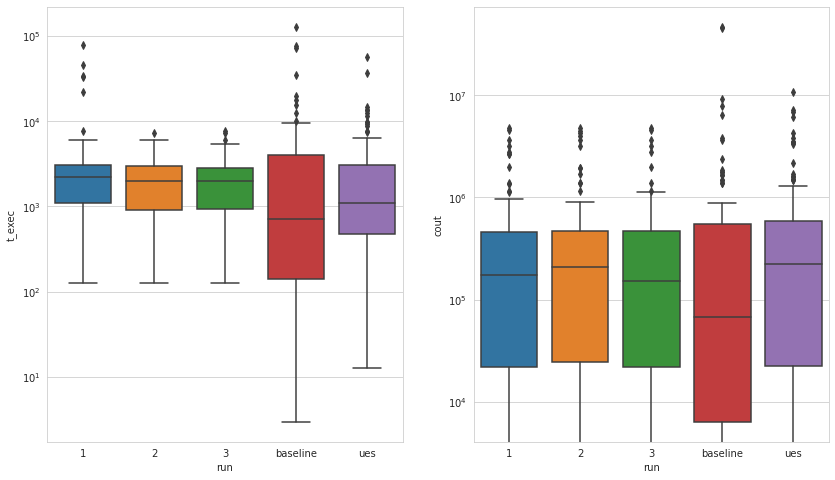

In [15]:
fig, (ax_t_exec, ax_cout) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
g = sns.boxplot(data=df_all, x="run", y="t_exec", ax=ax_t_exec)
g.set_yscale("log")
g = sns.boxplot(data=df_all, x="run", y="cout", ax=ax_cout)
g.set_yscale("log")

Now also considering the training time:

In [16]:
df_runtime = (grp_run.t_exec.sum() + grp_run.t_plan.sum()).to_frame(name="runtime")
df_time = df_runtime.merge(df_train, left_index=True, right_on="run", suffixes=("_exec", "_train"))
df_time["runtime_total"] = df_time.runtime_exec + df_time.runtime_train
df_time["runtime_train_seconds"] = df_time.runtime_train / 1000
df_time["runtime_total_minutes"] = df_time.runtime_total / 60000
df_time[["run", "runtime_train_seconds", "runtime_total_minutes"]]

,run,runtime_train_seconds,runtime_total_minutes
0,1,6.506,7.781486
0,2,6.758,4.282267
0,3,13.013,4.449148


## For which queries did BAO improve the execution time substantially?

We will now look at which hints lead to the most impressive execution time improvements. In order to do so, we will first quantify how much the execution time improved per query. Afterwards, we take a look at the (positive) outliers and extract the hints that BAO applied.

**First up, determine the improvement factor**:

In [17]:
grp_query = df_bao.groupby("label")

In [18]:
def t_exec_decrease(grp):
    init_t_exec = grp[grp.run == 1].t_exec
    final_t_exec = grp[grp.run == 3].t_exec
    return init_t_exec / final_t_exec

**Aggregated overview:** how is the improvement factor (values $> 1$ constitute an improvement) distributed?

In [19]:
ser_rt_dec = grp_query.apply(t_exec_decrease)
ser_rt_dec.describe()

count    112.000000
mean       3.010144
std        9.750307
min        0.624994
25%        0.971211
50%        0.992594
75%        1.007428
max       70.304762
Name: t_exec, dtype: float64

**Next up**, we extract the relevant data from the entire BAO data frame. This includes the query plan for the third benchmark iteration, as well as the initial/final execution time. This process is rather technical and does not really provide any insight.

In [20]:
df_query = df_bao[["label", "query", "plan", "t_exec", "run"]].copy()
df_query = df_query.join(ser_rt_dec.reset_index(level=0).set_index("label").squeeze(), on="label", rsuffix="_dec")

In [21]:
def restructure_df(df_grp):
    run3 = select(df_grp, run=3)
    final_plan = run3.plan
    init_t_exec = select(df_grp, run=1).t_exec
    final_t_exec = run3.t_exec
    return pd.Series({"final_plan" : unwrap(final_plan),
                      "t_exec_init": unwrap(init_t_exec),
                      "t_exec_final": unwrap(final_t_exec)})

In [22]:
df_summarized = df_query.groupby(["label", "query", "t_exec_dec"])[["t_exec", "plan", "run"]].apply(restructure_df).reset_index()

At this point we are ready to get the final BAO query hints.

In [23]:
def unwrap_bao_hint(plan):
    return plan[0]["Bao"]["Bao recommended hint"]

In [24]:
df_summarized["bao_hint"] = df_summarized.final_plan.apply(unwrap_bao_hint)
bao_cols = ["label", "t_exec_dec", "t_exec_init", "t_exec_final", "bao_hint"]

**Finally**, we can extract the good outliers from the benchmark. Which queries are considered outliers can be customized below. The factor is the upper boundary, i.e. setting it to 0.1 will select the top 10% of improvements, setting it to 0.25 will select the top 25%, etc.

In [25]:
outliers = 0.1

"Brilliant" or "excellent" queries are those queries have an improvement at least as large as the outlier-quantile boundary. This improvement factor is calculated now:

In [26]:
brilliant_t_exec_dec = df_summarized.t_exec_dec.quantile(1-outliers)
brilliant_t_exec_dec

1.0722870408837595

**At last, here are the queries:**

In [27]:
df_excellent = df_summarized[df_summarized.t_exec_dec >= brilliant_t_exec_dec]
df_excellent[bao_cols].sort_values(by="t_exec_dec")

,label,t_exec_dec,t_exec_init,t_exec_final,bao_hint
76,30b,1.074993,2802.085,2606.608,SET enable_mergejoin TO off; SET enable_indexs...
35,19b,1.191622,2755.721,2312.579,(no hint)
67,28c,1.270671,3852.261,3031.675,SET enable_mergejoin TO off;
11,13b,1.622089,3185.897,1964.070,SET enable_nestloop TO off;
69,29b,1.742963,4272.840,2451.480,SET enable_mergejoin TO off;
12,13c,1.776625,3133.198,1763.567,SET enable_nestloop TO off;
64,27c,13.843977,22407.391,1618.566,SET enable_mergejoin TO off; SET enable_indexs...
4,11b,14.077578,5419.614,384.982,SET enable_mergejoin TO off; SET enable_indexs...
52,23a,39.585222,33968.910,858.121,SET enable_mergejoin TO off;
53,23b,40.244946,33470.796,831.677,SET enable_mergejoin TO off;


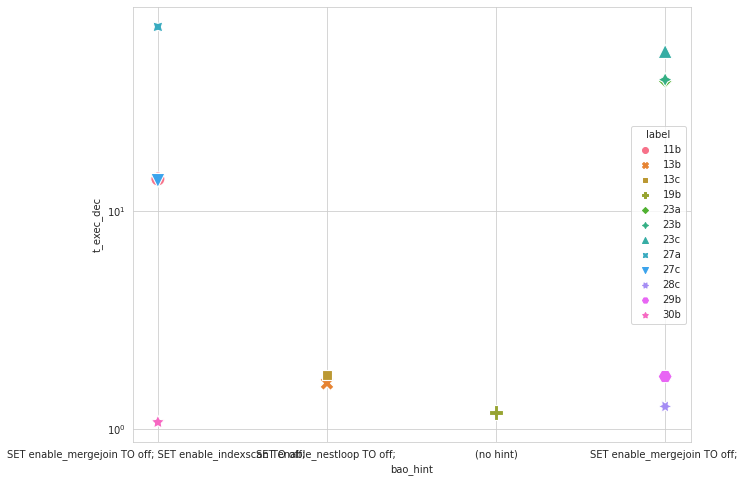

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(data=df_excellent, x="bao_hint", y="t_exec_dec", hue="label", style="label", s=200, ax=ax)
g.set_yscale("log")

## Which query hints did BAO apply during the benchmark?

In [29]:
df_bao["bao_hint"] = df_bao.plan.apply(unwrap_bao_hint)

The absolute number of times each query hint was applied per run:

In [30]:
bao_hint_hue_order = df_bao.bao_hint.sort_values().unique()

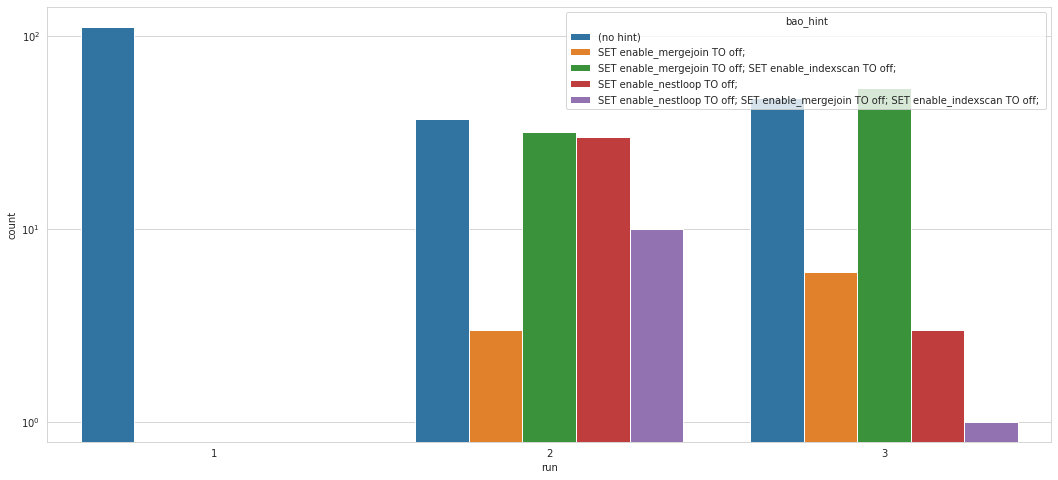

In [31]:
fig, ax = plt.subplots(figsize=(18,8))
g = sns.countplot(data=df_bao, x="run", hue="bao_hint", hue_order=bao_hint_hue_order, ax=ax)
g.set_yscale("log")

The influence each query hint had on the runtime, relative to the runtime during the previous iteration:

In [32]:
def per_iteration_runtime_improvement(query_grp):
    improvement = query_grp.t_exec.shift(1) / query_grp.t_exec
    return pd.DataFrame({"label": query_grp.label, "run": query_grp.run, "t_exec_rel_improv": improvement.values})

In [33]:
df_bao = df_bao.merge(df_bao.groupby("label").apply(per_iteration_runtime_improvement), on=["label", "run"])

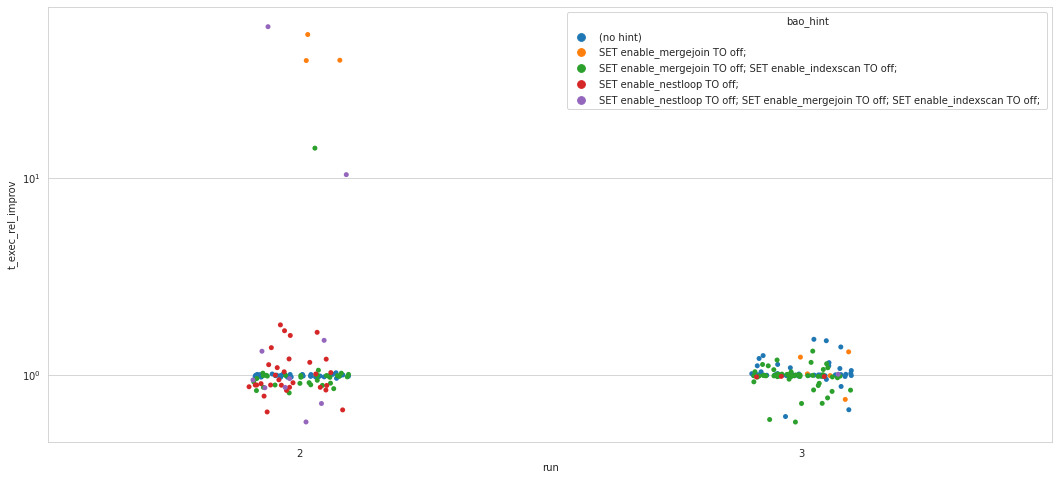

In [34]:
df_bao_r1_r2 = pd.concat([select(df_bao, run=2), select(df_bao, run=3)]).sort_values(by="bao_hint")
fig, ax = plt.subplots(figsize=(18,8))
g = sns.stripplot(data=df_bao_r1_r2, x="run", y="t_exec_rel_improv", hue="bao_hint", hue_order=bao_hint_hue_order, ax=ax)
g.set_yscale("log")

The improvement per benchmark iteration:

In [35]:
df_bao_r1_r2.groupby("run")["t_exec_rel_improv"].describe()

,count,mean,std,min,25%,50%,75%,max
run,,,,,,,,
2,112.0,2.878053,8.990951,0.579720,0.917232,0.994738,1.010450,58.794468
3,112.0,1.009299,0.143082,0.579233,0.987745,1.001477,1.019346,1.522965


## Compare full/reduced training workloads

In [36]:
workload_dfs_container = []
for workload in available_workloads:
    workload_iterations = read_workload_iterations(workload)
    for iteration in workload_iterations:
        iteration["workload"] = workload
    df_workload = pd.concat(workload_iterations)
    workload_dfs_container.append(df_workload)
df_workloads = pd.concat(workload_dfs_container).reset_index()
df_workloads

,index,query,cout,plan,t_exec,t_plan,label,run,workload
0,0,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",9359,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1628.297,35.353,3c,1,full-train
1,1,"SELECT COUNT(*) FROM company_type AS ct, info_...",46974,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",244.633,33.053,1d,1,full-train
2,2,"SELECT COUNT(*) FROM aka_title AS at, company_...",39302,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1043.781,56.711,15d,1,full-train
3,3,"SELECT COUNT(*) FROM complete_cast AS cc, comp...",1358376,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",3852.261,194.143,28c,1,full-train
4,4,"SELECT COUNT(*) FROM company_name AS cn1, comp...",8949,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",415.680,204.580,33a,1,full-train
...,...,...,...,...,...,...,...,...,...
673,108,"SELECT COUNT(*) FROM company_name AS cn1, comp...",7543,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",811.267,255.381,33b,3,small-train
674,109,"SELECT COUNT(*) FROM cast_info AS ci, info_typ...",29759,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",2189.270,83.969,18b,3,small-train
675,110,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",4975,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1385.787,78.431,3a,3,small-train
676,111,"SELECT COUNT(*) FROM info_type AS it1, info_ty...",93219,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1667.285,86.148,14b,3,small-train


In [37]:
grp_workloads = df_workloads.groupby(["workload", "run"])[["t_exec"]]

In [38]:
grp_workloads.describe()

t_exec                                                \
                 count         mean           std      min       25%   
workload    run                                                        
full-train  1    113.0  7149.012301  34815.052763  124.377  1119.300   
            2    113.0  2107.021425   1379.750188  127.003   935.975   
            3    113.0  2139.538602   1502.660394  125.950   941.571   
small-train 1    113.0  5260.240814  15868.353158  128.082  1132.474   
            2    113.0  2452.922584   3336.003955  125.526  1110.656   
            3    113.0  2775.316274   4455.558261  124.748  1085.060   

                                                 
                      50%       75%         max  
workload    run                                  
full-train  1    2233.308  3133.198  359959.310  
            2    1997.497  2993.124    7388.799  
            3    1999.016  2839.277    7735.888  
small-train 1    2276.196  3172.773  136405.311  
            2    2260.899  3006.572   34929.821  
            3    2301.668  3193.734   34450.099

In [39]:
df_workload_rts = grp_workloads.sum() / 60000
df_workload_rts

t_exec
workload    run           
full-train  1    13.463973
            2     3.968224
            3     4.029464
small-train 1     9.906787
            2     4.619671
            3     5.226846

In [40]:
df_workload_rts.reset_index(inplace=True)
rt_baseline = select(df_all, run="baseline").t_exec.sum() / 60000
rt_ues = select(df_all, run="ues").t_exec.sum() / 60000

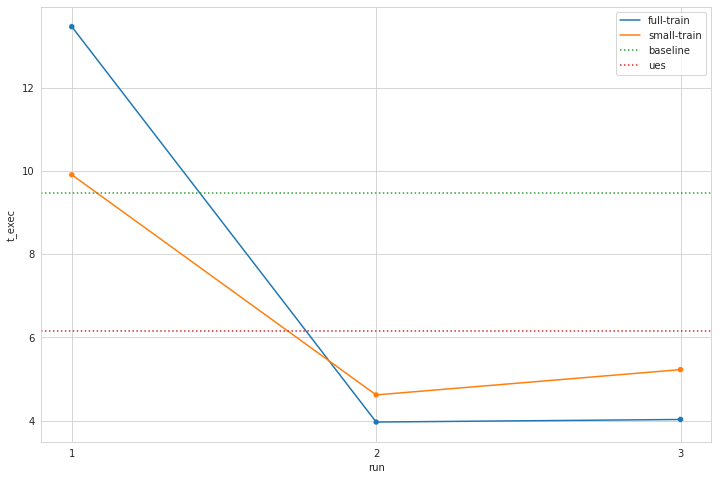

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.scatterplot(data=df_workload_rts, x="run", y="t_exec", hue="workload", ax=ax)
g = sns.lineplot(data=df_workload_rts, x="run", y="t_exec", hue="workload", ax=ax)
ax_base = g.axhline(rt_baseline, linestyle=":")
ax_ues = g.axhline(rt_ues, linestyle=":")

g.set_xticks(df_workload_rts.run.unique())

# beware, we need to use some internal APIs here!
next(ax._get_lines.prop_cycler)  # fast-forward one entry
base_color = next(ax._get_lines.prop_cycler)["color"]
ues_color = next(ax._get_lines.prop_cycler)["color"]
ax_base.set_color(base_color)
ax_ues.set_color(ues_color)

data_lines, _ = ax.get_legend_handles_labels()
base_line = matplotlib.lines.Line2D([0], [0], color=base_color, linestyle=":", label="baseline")
ues_line = matplotlib.lines.Line2D([0], [0], color=ues_color, linestyle=":", label="ues")
extended_handels = list(data_lines[2:])
extended_handels.extend([base_line, ues_line])
ax.legend(handles=extended_handels)

## Workloads without cached data

In [13]:
df1_nc, df2_nc, df3_nc = read_workload_iterations(w_nocache)

df_nc_raw = pd.concat([df1_nc, df2_nc, df3_nc])
df_nc = filter_heavy_hitters(df_nc_raw, exclude_heavy_hitter_pct).copy()

In [14]:
df_nc.groupby("run").t_exec.sum() / 60000

run
1    12.131780
2     4.512405
3     3.957278
Name: t_exec, dtype: float64

In [15]:
df_bao.groupby("run").t_exec.sum() / 60000

run
1    13.463973
2     3.968224
3     4.029464
Name: t_exec, dtype: float64